In [88]:
import numpy as np
import matplotlib.pyplot as plt
import random

import Models.OWID as owid
import Models.SIRD as sird
import Models.GradientDescent as gd

import scipy.optimize as opt

#parameters are [A(0), I(0), gamma0, gamma1, nu, beta0, beta1, beta2, u(t) vars]
#consts are [dayNum, I[0], maxI, len(u(t))]

#A' = (b0 / (1 + (b1 * I)**(b2 * u(t)) ) )*A - gamma0*A
#I' = gamma1*A - nu*I


def startFunc(consts):
    
    #return ukVars
    params = np.zeros(8)
        
    params[0] = .0005 + consts[1] #A(0), between 0 and 10 percent of the population
    params[1] = consts[1] #10e-10 + random.random()*.01 #I(0), between 0 and .1 percent of the population, avoid 0
    
    params[2] = .1 + random.random()*.4 #gamma0, asympt->recovs + infected - floor asympt infect rate
    params[3] = .005 + random.random()*.1 #gamma1, asympt->infected
    
    params[4] = .001 + random.random()*.03 #nu, infected -> recov or dead

    params[5] = .5 + random.random()*.2 #beta0, ceiling infectRate - floor infect rate
    params[6] = 50 + 100*random.random() #beta2, scaler on feedback
    params[7] = .5 + random.random()*5 #beta3, exponential [.5, 5.5]
    
    #beta1 = (b0/gamma0 - 1)**(1/u(t)*b2) / maxI
    #params[6] = ((params[5]/params[2])-1)**(1/(params[7])) / consts[2]
    
    
    return params
    
def simFunc(params, consts, giveA=False): #option to return A and I

    dayNum = consts[0]
    
    A = np.zeros((dayNum))
    I = np.zeros((dayNum))
    
    A[0] = params[0]
    I[0] = params[1]
    
    gamma0 = params[2]
    gamma1 = params[3]
    nu = params[4]
    
    beta = params[5:8]

    #print(params)
    
    #iterate the arrays using the definition K' and I'
    for t in range(len(I)-1): #define I and K on range [1, length)
        diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]
        diffI = gamma1*A[t] - nu*I[t]
        
        A[t+1] = diffA + A[t]
        I[t+1] = diffI + I[t]

    if(giveA):
        return A,I
        
    return I #I is the data generated

def constrainFunc(parameters, consts):
    
    params = np.copy(parameters)

    #fill the constraints
    paramConstraints = np.zeros((len(params),2)) #min, max for each one
    
    paramConstraints[0] = [.0000000001, .5] #A(0)
    paramConstraints[1] = [ 0.000000001, .25] #I(0)

    paramConstraints[2] = [0.00001, parameters[5]] #gamma0, has to be less than ceiling infection rate
    paramConstraints[3] = [0.00001, .9] #gamma1
    
    paramConstraints[4] = [0.00001, .9] #nu

    paramConstraints[5] = [.1, 100] #beta0, beta ceiling
    paramConstraints[6] = [.1, 100000] #beta1, feedback scaling
    paramConstraints[7] = [.25, 10] #beta2
    
    for i in range(len(params)): #exercise each constraint
        params[i] = min( max(paramConstraints[i,0], params[i]) , paramConstraints[i,1])
    
    return params

def graphParams(params, consts, graphA=False):
    A, I = simFunc(params, consts, giveA=True)
    
    fig, ax = plt.subplots(figsize=(18,8))
    if(graphA):
        ax.plot(A, color="orange", linestyle="dashed", alpha=.7)
    ax.plot(I, color="red")
    return fig, ax




#x is the starting params, args = (consts, y)
def errFunc(x, consts, slopeWeight, y):
    
    def simFunction(params, consts, giveA=False): #option to return A and I

        dayNum = consts[0]

        A = np.zeros((dayNum))
        I = np.zeros((dayNum))

        A[0] = params[0]
        I[0] = params[1]

        gamma0 = params[2]
        gamma1 = params[3]
        nu = params[4]

        beta = params[5:8]

        #print(params)

        #iterate the arrays using the definition K' and I'
        for t in range(len(I)-1): #define I and K on range [1, length)
            diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]
            diffI = gamma1*A[t] - nu*I[t]

            A[t+1] = diffA + A[t]
            I[t+1] = diffI + I[t]

        if(giveA):
            return A,I

        return I #I is the data generated

    x = simFunction(x, consts)
    
    error = 0
    for t in range(len(y)):
        error = error + (y[t] - x[t])**2 #squared error
    error = error / len(y) # / T, average error
    
    
    slopeError = 0
    if(slopeWeight!=0):
        dy = np.diff(y)
        dx = np.diff(x)
        for t in range(len(dy)):
            slopeError = slopeError + (dy[t] - dx[t])**2 #squared error
        slopeError = slopeError / len(dy) # / T, average error

    return error + slopeError*slopeWeight



def getParams(I, consts, slopeWeight=0, randomIterCount=100, method="SLSQP"):
    bestParams = startFunc(consts)
    bestError = 10e10 #arbitrary large value
    
    for i in range(randomIterCount):
        
        newParams = startFunc(consts)
        newParams = opt.minimize(errFunc, newParams, (consts, slopeWeight, I), method=method)['x']
        newError = errFunc(newParams, consts, slopeWeight, I)
    
        if(newError < bestError):
            bestError = newError
            bestParams = newParams
            print(i, "New best error: ", bestError)
            
    return bestParams

In [48]:
randomIterCount = 100
quickRunIters = 25 #how many interations on the first convergance
lastRunIters = 500
beginEta = .01 #large learnin rate for quick converging
finalEta = .01

slopeWeight = 1

C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in double_scalars


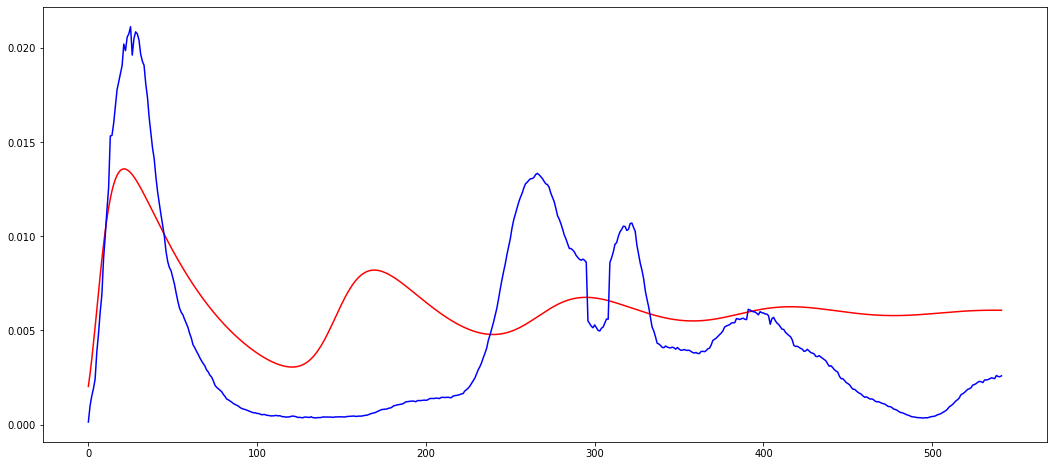

In [71]:
dates, I, R, D, V = owid.LoadCountryNormal("Italy") 
consts = [len(I), I[0], max(I), 0]

argList = (consts, slopeWeight, I)

startParams = startFunc(consts)

#print(startParams, argList)

finalParams = opt.minimize(errFunc, startParams, argList, method="SLSQP")['x']

fig,ax = graphParams(finalParams, consts)
ax.plot(I, color="blue")

## Italy

[4.00000000e-03 1.00000000e-03 3.80000000e-01 2.58706367e-02
 1.41079389e-02 5.83294346e-01 5.50000000e+01 1.00000000e+00]
[4.53992044e-02 9.56659730e-03 3.59914366e-01 2.58706367e-02
 1.41079389e-02 5.83294346e-01 1.37610949e+02 8.62065134e-01]


(0.0, 0.023256980589902283)

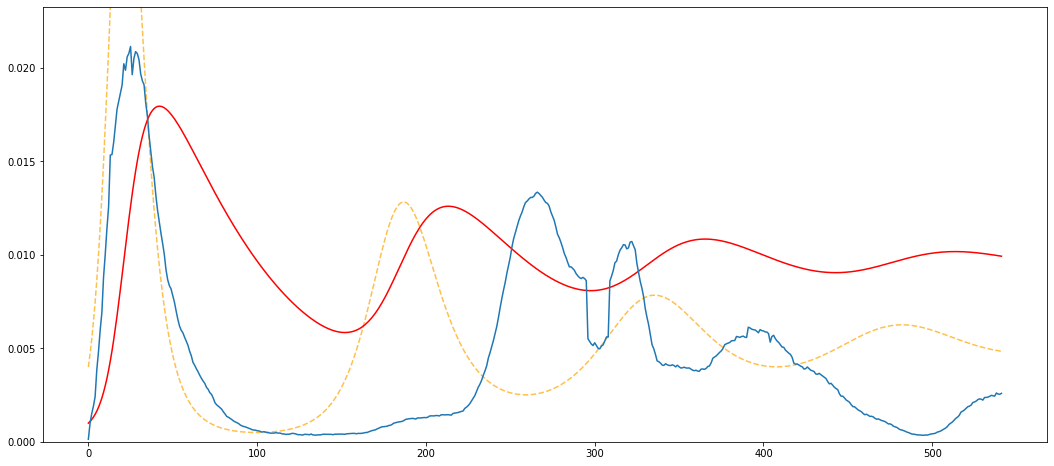

In [110]:
dates, I, R, D, V = owid.LoadCountryNormal("Italy")
consts = [len(I), I[0], max(I), 0]

#italyParams = getParams(I, consts, randomIterCount=250, slopeWeight=1, method = "SLSQP")

#italyParamsCopy = italyParams.copy()
italyParams = italyParamsCopy.copy()
italyParams[0] = .004
italyParams[1] = .001

italyParams[-2] = 55
italyParams[-1] = 1

italyParams[2]=.38
print(italyParams)
print(italyParamsCopy)


fig,ax = graphParams(italyParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## US

[1.00000000e-05 1.42348811e-03 4.64973141e-01 8.04993777e-02
 8.46785156e-03 5.50653000e-01 6.39965307e+01 1.77204492e+00]


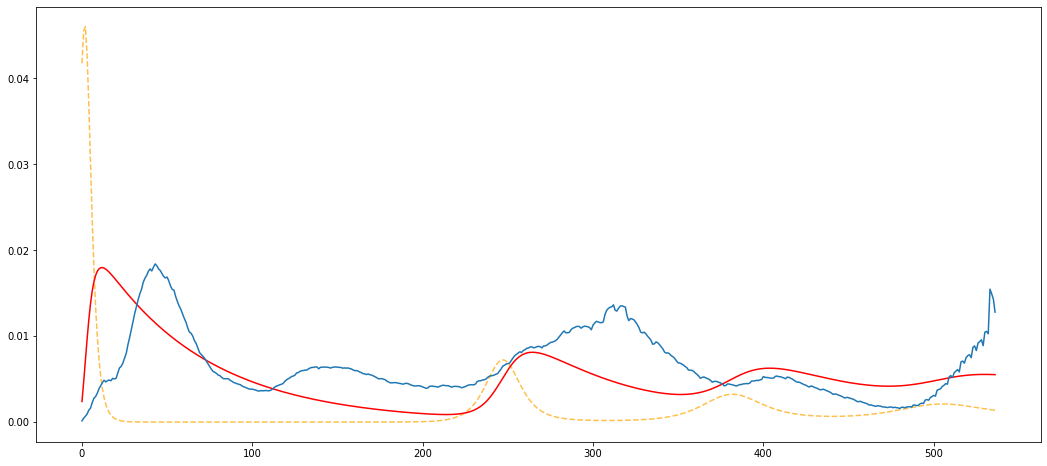

In [93]:
dates, I, R, D, V = owid.LoadCountryNormal("United States")
consts = [len(I), I[0], max(I), 0]

#usParams = getParams(I, consts, randomIterCount=250, slopeWeight=1, method = "SLSQP")

print(usParams)
usParamsCopy = usParams.copy()
usParams[0] = .00001

fig,ax = graphParams(italyParams, consts, graphA=True)
ax.plot(I)
#ax.set_ylim([0, max(I)*1.1])

## UK

C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in double_scalars


0 New best error:  0.0001961732647280528
1 New best error:  0.00015139557030584822
2 New best error:  0.0001500363241402878
3 New best error:  0.00014915680594520966
5 New best error:  0.00013466654558695935
6 New best error:  0.00012181066242203117
20 New best error:  8.571041273978193e-05
23 New best error:  7.627114356518643e-05
29 New best error:  7.312116914819771e-05
38 New best error:  7.253764160468938e-05


C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:146: RuntimeWarning: overflow encountered in double_scalars
C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:154: RuntimeWarning: overflow encountered in double_scalars


49 New best error:  5.171404514807748e-05


C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in double_scalars


129 New best error:  5.0258392399043027e-05
171 New best error:  4.712019410255812e-05


(0.0, 0.08622537289890751)

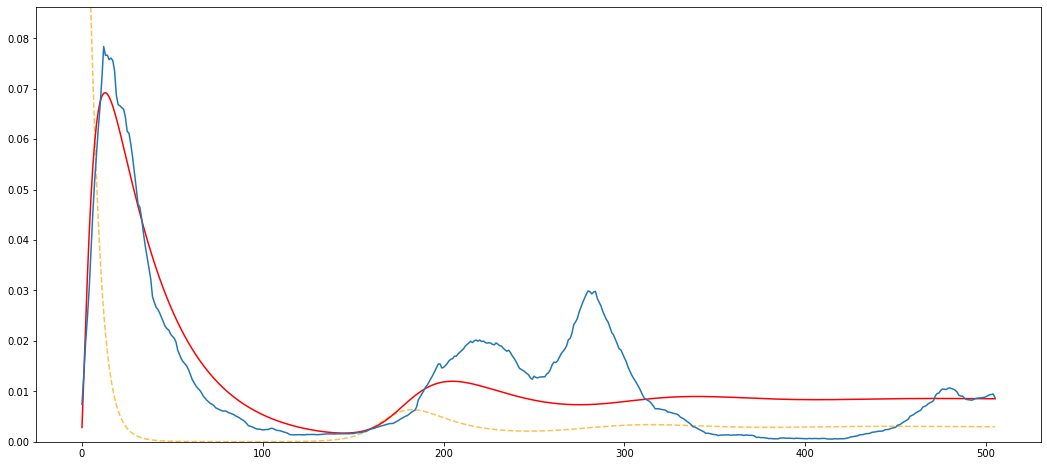

In [59]:
dates, I, R, D, V = owid.LoadCountryNormal("United Kingdom")
consts = [len(I), I[0], max(I), 0]

ukParams = getParams(I, consts, randomIterCount=250, slopeWeight=10, method = "SLSQP")

fig,ax = graphParams(ukParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Canada

0 New best error:  0.04768355781775051
4 New best error:  0.02678591701966909
13 New best error:  0.0258850106851289
14 New best error:  0.018964401315402748
16 New best error:  0.012849218303411429
22 New best error:  0.0066847592675282844
34 New best error:  0.005602239045881023
59 New best error:  0.0036722210633103004
66 New best error:  0.0009622523850123388
Startin Vars:
Error: 0.0009622523850123388
[6.60435360e-04 1.23786784e-04 4.34060095e-01 1.01500112e-01
 1.07725935e-02 5.80691788e-01 1.23453683e+02 5.90994170e-01]


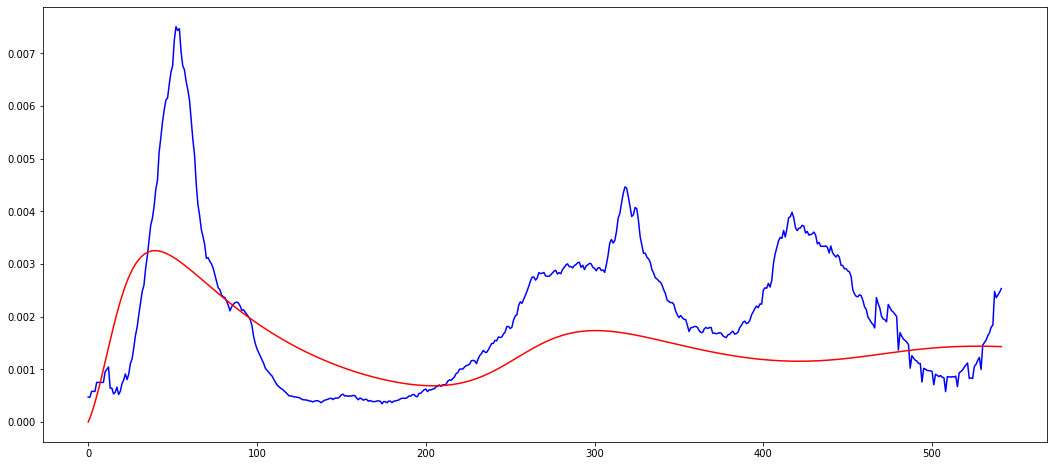

In [7]:
dates, I, R, D, V = owid.LoadCountryNormal("Canada") 

consts = [len(I), I[0], max(I), 0]

gradDesc = gd.GradDescent(I, consts, startFunc, simFunc, constrainFunc)

bestError = 100
gradDesc.eta = beginEta
    
for i in range(randomIterCount):
    gradDesc.solveVars(printOut=0, maxIteration=quickRunIters)
    
    if(gradDesc.getError() < bestError):
        bestError = gradDesc.getError()
        savedVars = gradDesc.params
        print(i, "New best error: ", bestError)

gradDesc.eta = finalEta
gradDesc.solveVars(params=savedVars, printOut=1000, maxIteration=lastRunIters)

canadaParams = gradDesc.params

gradDesc.x = gradDesc.simulate(gradDesc.params)

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(gradDesc.y, color="blue")
ax.plot(gradDesc.x, color="red")

## Mexico

0 New best error:  0.10273612477687365
1 New best error:  0.023252942908101412
12 New best error:  0.018808592064102906
19 New best error:  0.010880532492968269
20 New best error:  0.007387213019412128
37 New best error:  0.007359825914635699
64 New best error:  0.007121044496915288
78 New best error:  0.005960461532189978
81 New best error:  0.004529927175077931
98 New best error:  0.0017493408814753986
Startin Vars:
Error: 0.0017493408814753986
[3.07682076e-03 1.61848515e-03 3.89429390e-01 1.59361933e-02
 1.53136423e-02 5.22057610e-01 7.94684431e+01 8.65869417e-01]


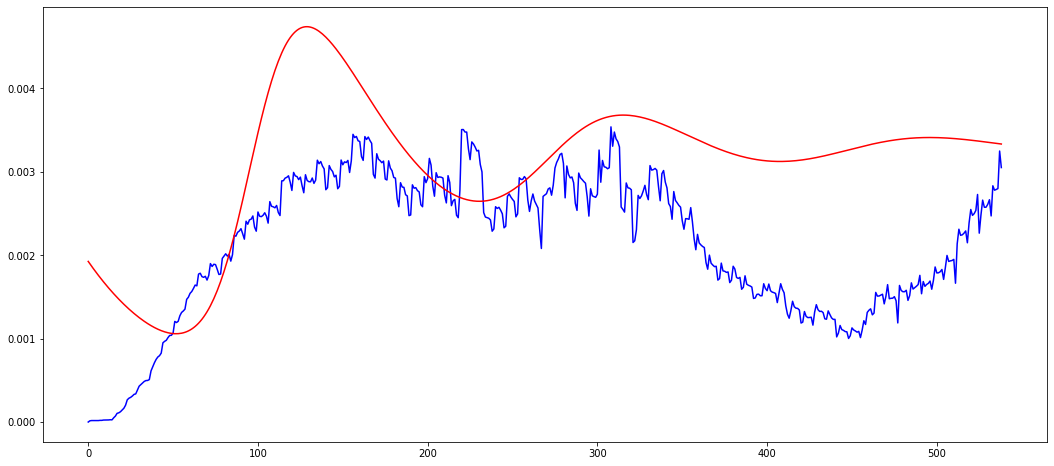

In [8]:
dates, I, R, D, V = owid.LoadCountryNormal("Mexico") 

consts = [len(I), I[0], max(I), 0]

gradDesc = gd.GradDescent(I, consts, startFunc, simFunc, constrainFunc)

bestError = 100
gradDesc.eta = beginEta
    
for i in range(randomIterCount):
    gradDesc.solveVars(printOut=0, maxIteration=quickRunIters)
    
    if(gradDesc.getError() < bestError):
        bestError = gradDesc.getError()
        savedVars = gradDesc.params
        print(i, "New best error: ", bestError)

gradDesc.eta = finalEta
gradDesc.solveVars(params=savedVars, printOut=1000, maxIteration=lastRunIters)

mexicoParams = gradDesc.params

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(gradDesc.y, color="blue")
ax.plot(gradDesc.x, color="red")

## Israel

0 New best error:  0.05539995786583012
1 New best error:  0.045224725349770845
2 New best error:  0.030411298452134326
3 New best error:  0.029081293681882912
18 New best error:  0.027893640472120354
37 New best error:  0.026817167388721617
81 New best error:  0.02655434085800334
Startin Vars:
Error: 0.02655434085800334
[3.90442849e-03 5.20468289e-03 1.99762020e-01 4.21277965e-02
 7.58469802e-03 6.66551959e-01 1.49446103e+02 3.43643894e+00]


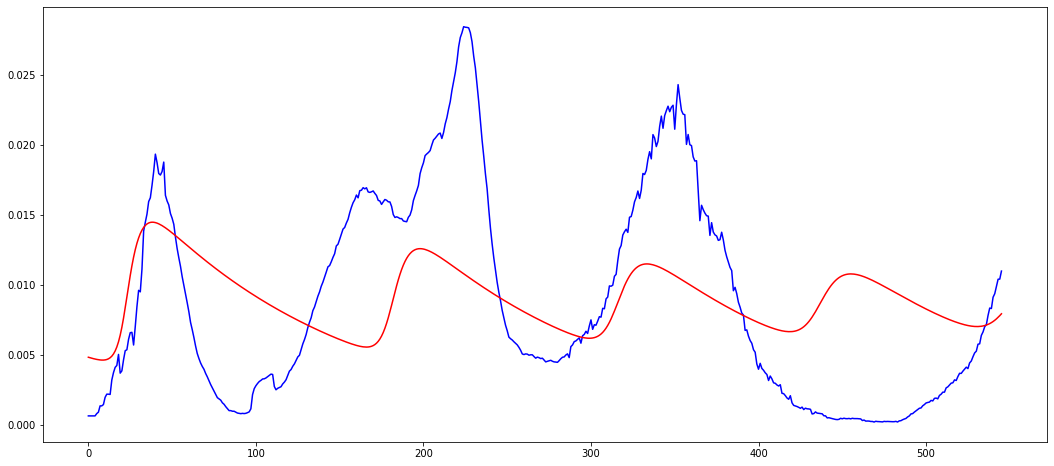

In [9]:
dates, I, R, D, V = owid.LoadCountryNormal("Israel") 

consts = [len(I), I[0], max(I), 0]

gradDesc = gd.GradDescent(I, consts, startFunc, simFunc, constrainFunc)

bestError = 100
gradDesc.eta = beginEta
    
for i in range(randomIterCount):
    gradDesc.solveVars(printOut=0, maxIteration=quickRunIters)
    
    if(gradDesc.getError() < bestError):
        bestError = gradDesc.getError()
        savedVars = gradDesc.params
        print(i, "New best error: ", bestError)

gradDesc.eta = finalEta
gradDesc.solveVars(params=savedVars, printOut=1000, maxIteration=lastRunIters)

israelParams = gradDesc.params

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(gradDesc.y, color="blue")
ax.plot(gradDesc.x, color="red")

## Russia

0 New best error:  0.015891469795528454
11 New best error:  0.011298434173799264
16 New best error:  0.005157351249311453
92 New best error:  0.003576335336632203
Startin Vars:
Error: 0.003576335336632203
[3.48277121e-02 3.47588463e-03 4.88737379e-01 2.01477320e-02
 1.68348447e-02 6.70879838e-01 6.21836114e+01 5.88592932e-01]


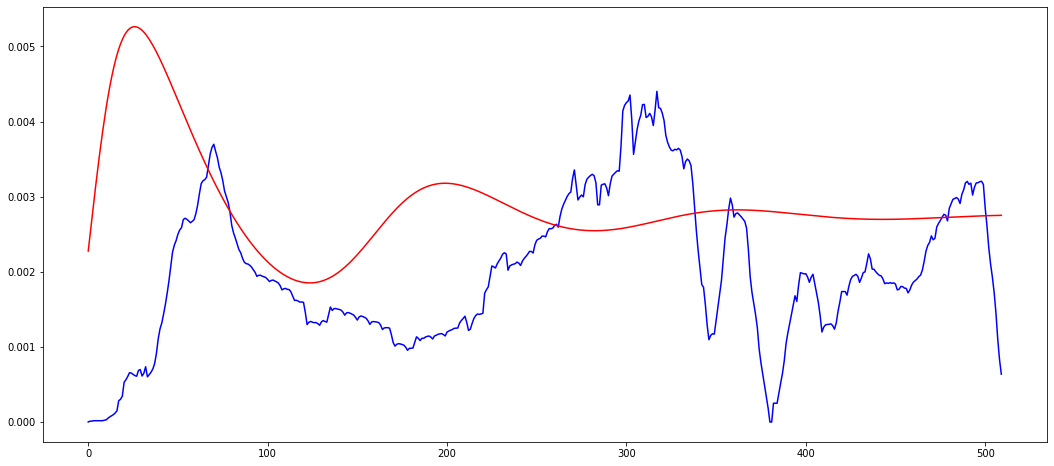

In [10]:
dates, I, R, D, V = owid.LoadCountryNormal("Russia") 

consts = [len(I), I[0], max(I), 0]

gradDesc = gd.GradDescent(I, consts, startFunc, simFunc, constrainFunc)

bestError = 100
gradDesc.eta = beginEta
    
for i in range(randomIterCount):
    gradDesc.solveVars(printOut=0, maxIteration=quickRunIters)
    
    if(gradDesc.getError() < bestError):
        bestError = gradDesc.getError()
        savedVars = gradDesc.params
        print(i, "New best error: ", bestError)

gradDesc.eta = finalEta
gradDesc.solveVars(params=savedVars, printOut=1000, maxIteration=lastRunIters)

russiaParams = gradDesc.params

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(gradDesc.y, color="blue")
ax.plot(gradDesc.x, color="red")

## South Africa

0 New best error:  0.00489307272790091
Startin Vars:
Error: 0.00489307272790091
[8.70872128e-03 4.84934863e-04 4.89408290e-01 7.22618668e-02
 1.41372538e-02 5.23267310e-01 8.53933414e+01 5.87225576e-01]


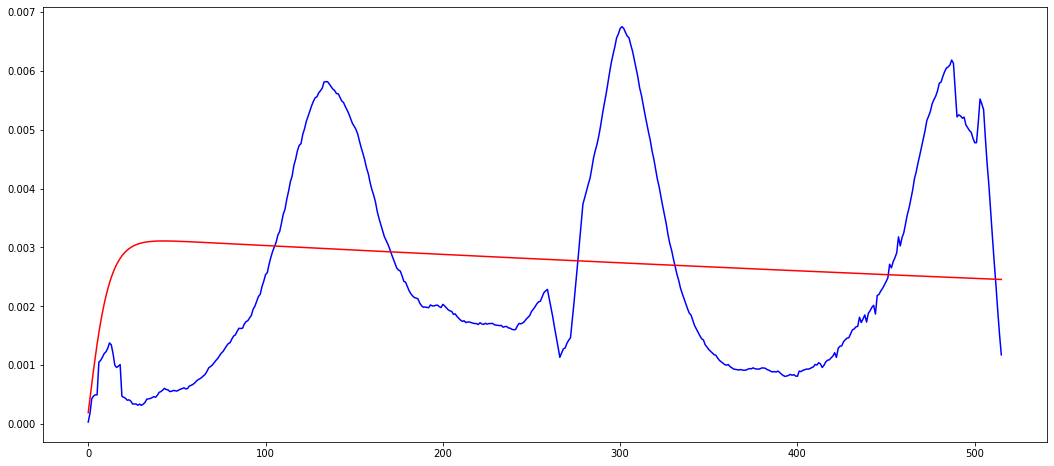

In [11]:
dates, I, R, D, V = owid.LoadCountryNormal("South Africa") 

consts = [len(I), I[0], max(I), 0]

gradDesc = gd.GradDescent(I, consts, startFunc, simFunc, constrainFunc)

bestError = 100
gradDesc.eta = beginEta
    
for i in range(randomIterCount):
    gradDesc.solveVars(printOut=0, maxIteration=quickRunIters)
    
    if(gradDesc.getError() < bestError):
        bestError = gradDesc.getError()
        savedVars = gradDesc.params
        print(i, "New best error: ", bestError)

gradDesc.eta = finalEta
gradDesc.solveVars(params=savedVars, printOut=1000, maxIteration=lastRunIters)

southAfricaParams = gradDesc.params

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(gradDesc.y, color="blue")
ax.plot(gradDesc.x, color="red")

## Australia

0 New best error:  0.2531017346952069
1 New best error:  0.04499368074056303
2 New best error:  0.007788057387217035
17 New best error:  0.00412615887452152
Startin Vars:
Error: 0.00412615887452152
[4.29649490e-02 3.00420332e-03 4.23525198e-01 2.13894883e-02
 1.49697983e-02 5.67291119e-01 1.26253964e+02 6.87300189e-01]


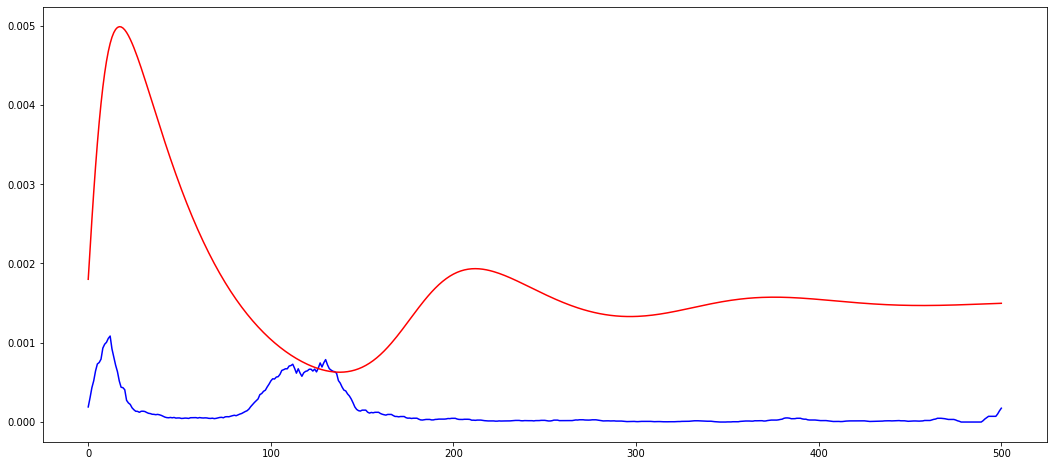

In [14]:
dates, I, R, D, V = owid.LoadCountryNormal("Australia") 

consts = [len(I), I[0], max(I), 0]

gradDesc = gd.GradDescent(I, consts, startFunc, simFunc, constrainFunc)

bestError = 100
gradDesc.eta = beginEta
    
for i in range(randomIterCount):
    gradDesc.solveVars(printOut=0, maxIteration=quickRunIters)
    
    if(gradDesc.getError() < bestError):
        bestError = gradDesc.getError()
        savedVars = gradDesc.params
        print(i, "New best error: ", bestError)

gradDesc.eta = finalEta
gradDesc.solveVars(params=savedVars, printOut=1000, maxIteration=lastRunIters)

australiaParams = gradDesc.params

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(gradDesc.y, color="blue")
ax.plot(gradDesc.x, color="red")

## Turkey

0 New best error:  0.22843872419870026
1 New best error:  0.016421481307007366
2 New best error:  0.0068639418988188546
21 New best error:  0.004764128474940361
25 New best error:  0.0027140734127987422
Startin Vars:
Error: 0.0027140734127987422
[1.23977667e-02 1.59973792e-03 4.93293426e-01 1.14687360e-02
 7.21722949e-03 5.84326714e-01 1.39065674e+02 2.01471183e+00]


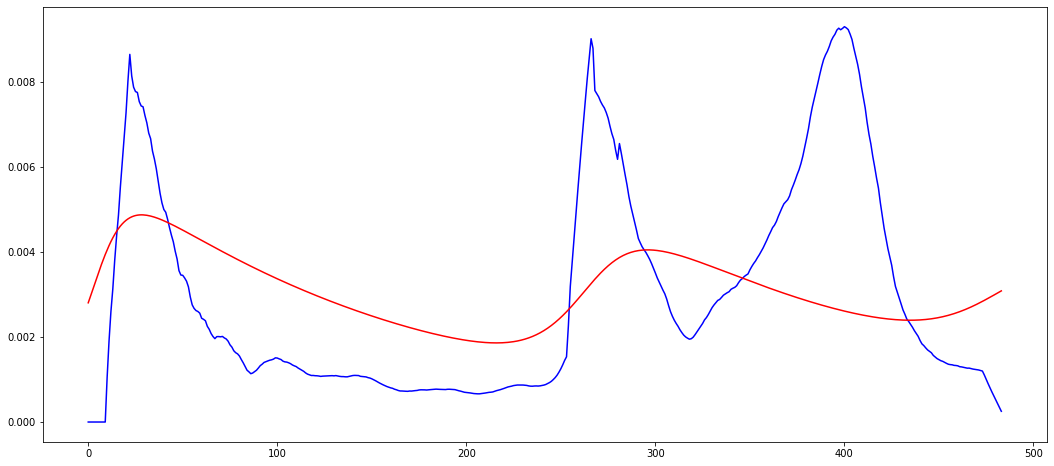

In [13]:
dates, I, R, D, V = owid.LoadCountryNormal("Turkey") 

consts = [len(I), I[0], max(I), 0]

gradDesc = gd.GradDescent(I, consts, startFunc, simFunc, constrainFunc)

bestError = 100
gradDesc.eta = beginEta
    
for i in range(randomIterCount):
    gradDesc.solveVars(printOut=0, maxIteration=quickRunIters)
    
    if(gradDesc.getError() < bestError):
        bestError = gradDesc.getError()
        savedVars = gradDesc.params
        print(i, "New best error: ", bestError)

gradDesc.eta = finalEta
gradDesc.solveVars(params=savedVars, printOut=1000, maxIteration=lastRunIters)

turkeyParams = gradDesc.params

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(gradDesc.y, color="blue")
ax.plot(gradDesc.x, color="red")

In [2]:
#params = startFunc(consts)
#paramsOrig = params.copy()
print(paramsOrig)

params[0] = .03
params[1] = 0

params[2] = .3
params[3] = .01
params[4] = .01
params[-2] = 60
params[-1] = 2

fig, ax = graphParams(params, consts)

ax.plot(I, color="blue")

ax.set_ylim([0, .02])

NameError: name 'paramsOrig' is not defined